# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [931]:
!pip install progressbar

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [932]:
import pandas as pd
import numpy as np
import math, json, re, os

import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from clean_data import * 
from exploratory_data_analysis import *

%matplotlib inline

## Read data from JSON file

* Check dataframe and familiarise with data 

In [933]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [934]:
portfolio.shape, profile.shape, transcript.shape

((10, 6), (17000, 5), (306534, 4))

In [935]:
portfolio.info() # No missing values in portfolio dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
reward        10 non-null int64
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
offer_type    10 non-null object
id            10 non-null object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [936]:
profile.info() # missing values in profile dataframe (gender and income)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [937]:
profile.shape[0] - profile.isnull().sum() 

gender              14825
age                 17000
id                  17000
became_member_on    17000
income              14825
dtype: int64

Profile dataframe has missing values (gender and income) 

In [938]:
transcript.info() # No missing values in transcript dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
person    306534 non-null object
event     306534 non-null object
value     306534 non-null object
time      306534 non-null int64
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [939]:
#pd.get_dummies()

In [940]:
# offer master database 
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [941]:
# Customer master 
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [942]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [943]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [944]:
transcript.columns

Index(['person', 'event', 'value', 'time'], dtype='object')

In [945]:
#transcript[['event', 'offerid', 'profileid', 'timedays', 'reward', 'amount']]
#transcript.groupby(['offerid', 'profileid'])[['timedays', 'reward', 'amount', 'event']].head()

In [946]:
#76277+57725 + 33579
#57725 + 33579
#transcript.groupby(['profileid', 'offerid'])['event'].count()

In [947]:
#portfolio = clean_portfolio() 
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [948]:
profile.isnull().sum(axis=0) * 100 / profile.shape[0]

gender              12.794118
age                  0.000000
id                   0.000000
became_member_on     0.000000
income              12.794118
dtype: float64

In [949]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [950]:
# '%' sex split where gender is specified
profile['gender'].value_counts()*100/ profile['gender'].count()

M    57.227656
F    41.342327
O     1.430017
Name: gender, dtype: float64

In [951]:
# '%' sex split as per overall profile count 
profile['gender'].value_counts()*100/ profile.count()[1]

M    49.905882
F    36.052941
O     1.247059
Name: gender, dtype: float64

In [952]:
# EDA Analysis

In [953]:
profile.isnull().sum() 

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [954]:
profile.income.isnull().sum()

2175

In [955]:
profile[profile['age']==118].count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

In [956]:
profile[profile['gender']=='O'].count()

gender              212
age                 212
id                  212
became_member_on    212
income              212
dtype: int64

In [957]:
profile.dropna(axis=0, inplace=True)

In [958]:
profile.shape

(14825, 5)

In [959]:
profile[profile['age']==118].count()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [960]:
profile[profile['gender']=='O'].index

Int64Index([   31,   273,   383,   513,   576,   851,   889,   895,   979,
              981,
            ...
            16278, 16391, 16611, 16620, 16648, 16670, 16683, 16731, 16741,
            16920],
           dtype='int64', length=212)

In [961]:
profile.drop(profile[profile['gender']=='O'].index, inplace=True)

In [962]:
profile.gender.unique()

array(['F', 'M'], dtype=object)

In [963]:
portfolio.shape, profile.shape, transcript.shape

((10, 6), (14613, 5), (306534, 4))

In [964]:
# Profile Shape + deleted Gender details which are not specified  + where age and income is not specified
profile.shape[0] + 212 + 2175

17000

In [965]:
profile.head()

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


In [966]:
profile.dtypes

gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object

In [967]:
profile['became_member_on'] = profile['became_member_on'].apply(lambda x:  pd.to_datetime(x, format='%Y%m%d'))

profile['year'] = profile['became_member_on'].apply(lambda x: x.year)
#profile['month'] = profile['became_member_on'].apply(lambda x: x.month)
#profile['day'] = profile['became_member_on'].apply(lambda x: x.day)
profile['weekday'] = profile['became_member_on'].apply(lambda x: x.weekday())
profile['weekdayname'] = profile['became_member_on'].apply(lambda x: x.day_name())

profile['gender'] = profile['gender'].apply(lambda x : 'Male' if (x == 'M') else 'Female')
profile['gender'] = profile.gender.astype(str)

# Change the columnn name of the profile dataframe from 'id' column to 'profileid'
profile.rename(columns={"id": "profileid"}, inplace=True)

# Change the columnn name of the portfolio dataframe from 'id' column to 'offerid'
portfolio.rename(columns={"id": "offerid"}, inplace=True)

# Change the columnn name of the transcript dataframe from 'person' column to 'customerid'
transcript.rename(columns={'person': 'customerid'}, inplace=True)

# Change the columnn name of the transcript dataframe from 'time' column to 'timedays'
transcript.rename(columns={'time': 'timedays'}, inplace=True)

In [968]:
def impute_Age(arg_age):        
    if (arg_age<=20):
        return '0-20'
    elif ((arg_age>20) & (arg_age<=40)):
        return '20-40'
    elif ((arg_age>40) & (arg_age<=60)):
        return '40-60'
    elif ((arg_age>60) & (arg_age<=80)):
        return '60-80'
    elif ((arg_age>80) & (arg_age<=100)):
        return '80-100'
    elif ((arg_age>100) & (arg_age<=120)):
        return '110-120'
    else:
        return '120+'

def impute_Age_number(arg_age):        
    if (arg_age<=20):
        return 1
    elif ((arg_age>20) & (arg_age<=40)):
        return 2
    elif ((arg_age>40) & (arg_age<=60)):
        return 3
    elif ((arg_age>60) & (arg_age<=80)):
        return 4
    elif ((arg_age>80) & (arg_age<=100)):
        return 5
    elif ((arg_age>100) & (arg_age<=120)):
        return 6
    else:
        return 7

In [969]:
profile['agegroup'] = profile['age'].apply(impute_Age)
profile['agegroupnum'] = profile['age'].apply(impute_Age_number)

In [970]:
profile.head(2)

,gender,age,profileid,became_member_on,income,year,weekday,weekdayname,agegroup,agegroupnum
1,Female,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,5,Saturday,40-60,3
3,Female,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,1,Tuesday,60-80,4


In [971]:
profile.dtypes

gender                      object
age                          int64
profileid                   object
became_member_on    datetime64[ns]
income                     float64
year                         int64
weekday                      int64
weekdayname                 object
agegroup                    object
agegroupnum                  int64
dtype: object

In [972]:
profile.gender.unique()

array(['Female', 'Male'], dtype=object)

In [973]:
# -------- Profile Clean is done 


In [974]:
# Now start with Transaction cleanup

In [975]:
transcript.head()

,customerid,event,value,timedays
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [976]:
val_split = transcript['value'].apply(pd.Series)

In [977]:
val_split['offer id'].isna().count(), val_split.count()#.head()

(306534, offer id    134002
 amount      138953
 offer_id     33579
 reward       33579
 dtype: int64)

In [978]:
def mergeofferid(col):
    offid_1 = col[0]
    offid_2 = col[1]
    

    if ((offid_1=='') | pd.isnull(offid_1)): #| np.isnan(offid_1)):
        return offid_2
    elif ((offid_2=='') | pd.isnull(offid_2)):# | np.isnan(offid_2)):
        return offid_1
    else:
        return "NA"

val_split['offerid'] = val_split[['offer id', 'offer_id']].apply(mergeofferid, axis=1)

In [979]:
val_split.drop(['offer id','offer_id'], axis=1, inplace=True)#[val_split['offerid'].isna()]

In [980]:
#val_split.fillna(0, inplace=True)

In [981]:
val_split.head()

,amount,reward,offerid
0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [982]:
transcript.drop('value', axis=1, inplace=True)
transcript.head()

,customerid,event,timedays
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0
2,e2127556f4f64592b11af22de27a7932,offer received,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0


In [983]:
transcript = pd.concat([transcript, val_split], axis=1)

In [984]:
transcript.columns

Index(['customerid', 'event', 'timedays', 'amount', 'reward', 'offerid'], dtype='object')

In [985]:
# Create a DataFrame that describes customer transactions
column_order = ['event', 'offerid', 'customerid', 'timedays', 'reward', 'amount']
transcript = transcript[column_order]
    
transcript.head()

,event,offerid,customerid,timedays,reward,amount
0,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN
1,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN
2,offer received,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0,NaN,NaN
3,offer received,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,NaN
4,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,68617ca6246f4fbc85e91a2a49552598,0,NaN,NaN


In [986]:
#transcript.groupby(['offerid', 'event'])['amount','reward'].sum()
transcript.groupby(['offerid'])['amount','reward'].sum()

,amount,reward
offerid,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,17100.0
2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,15468.0
2906b810c7d4411798c6938adc9daaa5,0.0,8034.0
3f207df678b143eea3cee63160fa8bed,0.0,0.0
4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,33310.0
5a8bc65990b245e5a138643cd4eb9837,0.0,0.0
9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,21770.0
ae264e3637204a6fb9bb56bc8210ddfd,0.0,36880.0
f19421c1d4aa40978ebb69ca19b0e20d,0.0,21480.0


In [987]:
# transcript clean up is complete

In [988]:
# -----------------

In [989]:
transcript.rename(columns={"customerid": "profileid"}, inplace=True)
transcript.head(2)

,event,offerid,profileid,timedays,reward,amount
0,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN
1,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN


In [990]:
profile.head(2)

,gender,age,profileid,became_member_on,income,year,weekday,weekdayname,agegroup,agegroupnum
1,Female,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,5,Saturday,40-60,3
3,Female,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,1,Tuesday,60-80,4


In [991]:
portfolio.head(2)

,reward,channels,difficulty,duration,offer_type,offerid
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


In [992]:
########------------ 
#aaa

In [993]:
#clean_data = transcript.merge(portfolio, on='offerid')
clean_data = pd.merge(transcript, portfolio,  how='left', left_on=['offerid'], right_on = ['offerid'])


In [994]:
clean_data.rename(columns={"reward_x": "customerreward"}, inplace=True)
clean_data.rename(columns={"reward_y": "offerreward"}, inplace=True)


In [995]:
clean_data.head(2)

,event,offerid,profileid,timedays,customerreward,amount,offerreward,channels,difficulty,duration,offer_type
0,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo
1,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,5.0,"[web, email]",20.0,10.0,discount


In [996]:
#clean_data = clean_data.merge(transcript, on=['profileid'])
clean_data = pd.merge(clean_data, profile,  how='left', 
                      left_on=['profileid'], 
                      right_on = ['profileid'])

In [997]:
clean_data.columns

Index(['event', 'offerid', 'profileid', 'timedays', 'customerreward', 'amount',
       'offerreward', 'channels', 'difficulty', 'duration', 'offer_type',
       'gender', 'age', 'became_member_on', 'income', 'year', 'weekday',
       'weekdayname', 'agegroup', 'agegroupnum'],
      dtype='object')

In [998]:
clean_data.rename(columns={"offer_type": "offertype"}, inplace=True)
clean_data.rename(columns={"became_member_on": "becamememberon"}, inplace=True)

In [999]:
clean_data.head(5)

,event,offerid,profileid,timedays,customerreward,amount,offerreward,channels,difficulty,duration,offertype,gender,age,becamememberon,income,year,weekday,weekdayname,agegroup,agegroupnum
0,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,Female,75.0,2017-05-09,100000.0,2017.0,1.0,Tuesday,60-80,4.0
1,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,5.0,"[web, email]",20.0,10.0,discount,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,offer received,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,2.0,"[web, email, mobile]",10.0,7.0,discount,Male,68.0,2018-04-26,70000.0,2018.0,3.0,Thursday,60-80,4.0
3,offer received,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,NaN,2.0,"[web, email, mobile, social]",10.0,10.0,discount,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,68617ca6246f4fbc85e91a2a49552598,0,NaN,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [1000]:
# prepare exploratory graph

In [1001]:
clean_data.columns

Index(['event', 'offerid', 'profileid', 'timedays', 'customerreward', 'amount',
       'offerreward', 'channels', 'difficulty', 'duration', 'offertype',
       'gender', 'age', 'becamememberon', 'income', 'year', 'weekday',
       'weekdayname', 'agegroup', 'agegroupnum'],
      dtype='object')

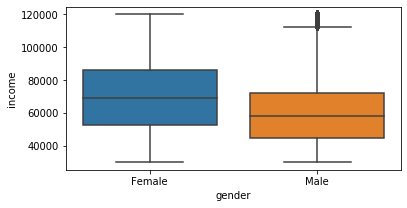

In [1002]:
plt.figure(figsize=(6,3))
sns.boxplot(x='gender', y='income', data=clean_data)

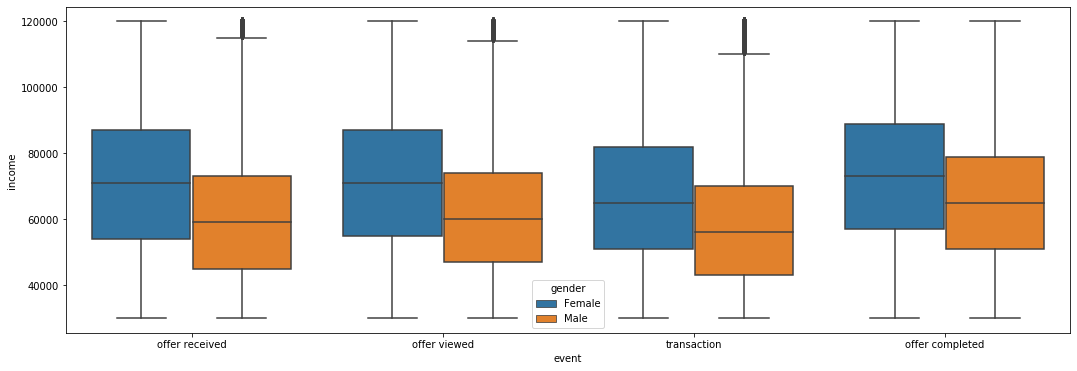

In [1003]:
plt.figure(figsize=(18,6))
sns.boxplot(x='event', y='income', hue='gender', data=clean_data)
plt.show()
#sns.factorplot(x="event", y="income", hue="gender", col="offertype",data=clean_data, kind="box", size=4, aspect=.7)

In [1004]:
#sns.jointplot(x='gender',y='customerreward', data=clean_data)


In [1005]:
['event', 'offerid', 'profileid', 'timedays', 'customerreward', 'amount',
       'channels', 'difficulty', 'duration', 'offertype', 'offerreward', 'age',
       'becamememberon', 'gender', 'income', 'year', 'weekday', 'weekdayname',
       'agegroup', 'agegroupnum']

['event',
 'offerid',
 'profileid',
 'timedays',
 'customerreward',
 'amount',
 'channels',
 'difficulty',
 'duration',
 'offertype',
 'offerreward',
 'age',
 'becamememberon',
 'gender',
 'income',
 'year',
 'weekday',
 'weekdayname',
 'agegroup',
 'agegroupnum']

In [1006]:
#aaaaa

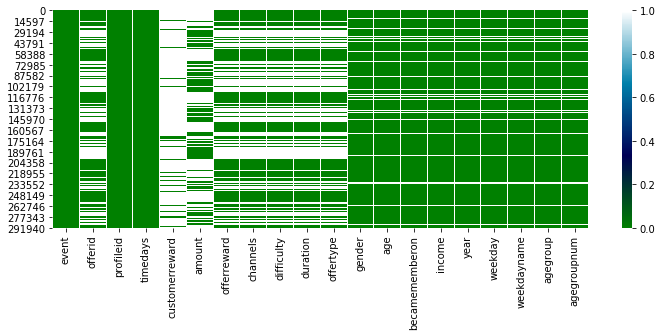

In [1007]:
plt.figure(figsize=(12,4))
sns.heatmap(clean_data.isnull(), cmap='ocean')

In [1008]:
# Removing and filling NA

In [1009]:
saleswithoutoffer = clean_data[clean_data['event']=='transaction']
saleswithoffer = clean_data[clean_data['event'].isin(['offer received', 'offer viewed', 'offer completed'])]

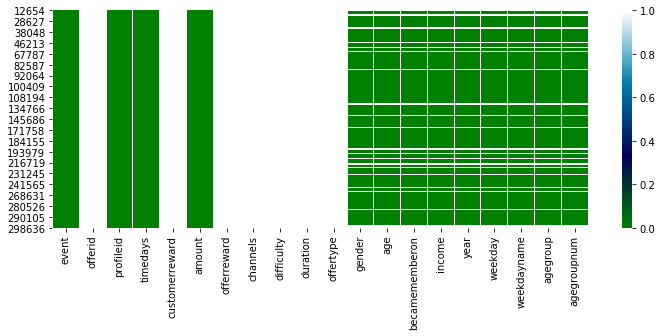

In [1010]:
plt.figure(figsize=(12,4))
sns.heatmap(saleswithoutoffer.isnull(), cmap='ocean')

In [1011]:
saleswithoutoffer_final = saleswithoutoffer.drop(['offerid', 'channels', 'customerreward',
                        'difficulty', 'duration','offertype', 'offerreward'], axis=1)
saleswithoutoffer_final.dropna(axis=0,inplace=True)

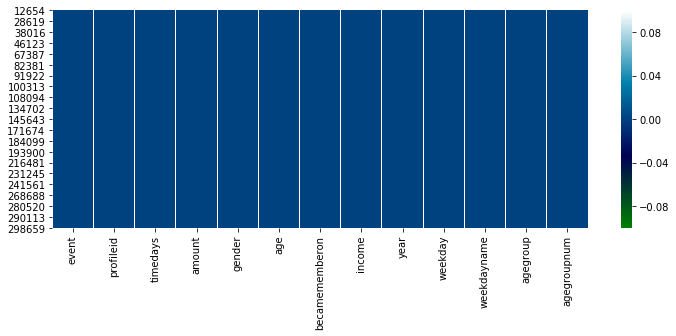

In [1012]:
#saleswithoutoffer_final.isnull().sum()
plt.figure(figsize=(12,4))
sns.heatmap(saleswithoutoffer_final.isnull(), cmap='ocean')

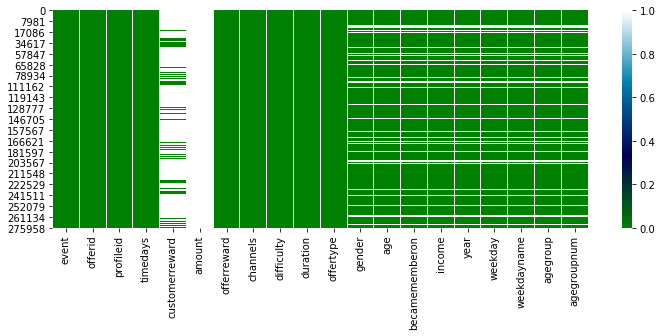

In [1013]:
plt.figure(figsize=(12,4))
sns.heatmap(saleswithoffer.isnull(), cmap='ocean')

In [1014]:
saleswithoffer_final = saleswithoffer.drop(['amount'], axis=1)
saleswithoffer_final['customerreward'].fillna(0, inplace=True)

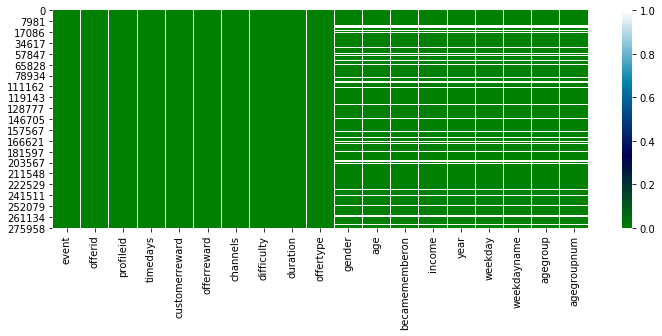

In [1015]:
plt.figure(figsize=(12,4))
sns.heatmap(saleswithoffer_final.isnull(), cmap='ocean')

In [1016]:
saleswithoffer_final[saleswithoffer_final['age'].isnull()]

,event,offerid,profileid,timedays,customerreward,offerreward,channels,difficulty,duration,offertype,gender,age,becamememberon,income,year,weekday,weekdayname,agegroup,agegroupnum
1,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43,0,0.0,5.0,"[web, email]",20.0,10.0,discount,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,offer received,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586,0,0.0,2.0,"[web, email, mobile, social]",10.0,10.0,discount,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,68617ca6246f4fbc85e91a2a49552598,0,0.0,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
6,offer received,2298d6c36e964ae4a3e7e9706d1fb8c2,c4863c7985cf408faee930f111475da3,0,0.0,3.0,"[web, email, mobile, social]",7.0,7.0,discount,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
10,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,744d603ef08c4f33af5a61c8c7628d1c,0,0.0,5.0,"[web, email]",20.0,10.0,discount,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306235,offer completed,fafdcd668e3743c1bb461111dcafc2a4,61a2713a058b4ee782d1fbeced01b400,714,2.0,2.0,"[web, email, mobile, social]",10.0,10.0,discount,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
306421,offer viewed,ae264e3637204a6fb9bb56bc8210ddfd,89417e13fcd54dd78b80f97f7f085cf1,714,0.0,10.0,"[email, mobile, social]",10.0,7.0,bogo,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
306441,offer viewed,5a8bc65990b245e5a138643cd4eb9837,d56386cf344c4829bbf420d1895dca37,714,0.0,0.0,"[email, mobile, social]",0.0,3.0,informational,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
306497,offer completed,2298d6c36e964ae4a3e7e9706d1fb8c2,a6f84f4e976f44508c358cc9aba6d2b3,714,3.0,3.0,"[web, email, mobile, social]",7.0,7.0,discount,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [1017]:
#profile.columns
profile[profile['profileid'] == 'a03223e636434f42ac4c3df47e8bac43']

,gender,age,profileid,became_member_on,income,year,weekday,weekdayname,agegroup,agegroupnum


In [1018]:
#profile[profile['profileid'].isin()]
saleswithoffer_final[saleswithoffer_final['age'].isnull()]['profileid'].unique()


array(['a03223e636434f42ac4c3df47e8bac43',
       '8ec6ce2a7e7949b1bf142def7d0e0586',
       '68617ca6246f4fbc85e91a2a49552598', ...,
       '912b9f623b9e4b4eb99b6dc919f09a93',
       'c77659a28bf84aaa95b1ca4bbb2b56d0',
       '6e1d4ac6dc3d4a9788b1b82ea4ae6ebf'], dtype=object)

In [1019]:
saleswithoffer_final[saleswithoffer_final['age'].isnull()]['event'].value_counts()

offer received     10692
offer viewed        8638
offer completed     1636
Name: event, dtype: int64

In [1020]:
# Remove customer id's that are not in the customer profile DataFrame
select_data = saleswithoffer_final['profileid'].isin(profile['profileid'])
saleswithoffer_final = saleswithoffer_final[select_data]

percent_removed = 100 * (1 - select_data.sum() / saleswithoffer_final.shape[0])
print("Percentage of transactions removed: %.2f %%" % percent_removed)

# Convert from hours to days
saleswithoffer_final['timedays'] /= 24.0

Percentage of transactions removed: 0.00 %


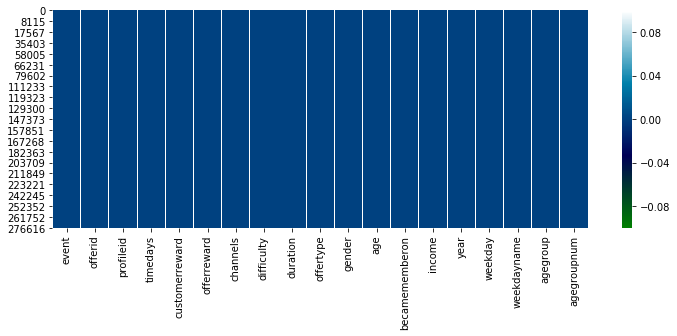

In [1021]:
plt.figure(figsize=(12,4))
sns.heatmap(saleswithoffer_final.isnull(), cmap='ocean')

In [1022]:
saleswithoffer_final['event'].value_counts()

offer received     65585
offer viewed       49087
offer completed    31943
Name: event, dtype: int64

In [1023]:
saleswithoffer_final['sucessful_unsuccessful'] = saleswithoffer_final['event'].apply(lambda x : 1 if (x == 'offer completed') else 0)
#saleswithoffer_final[saleswithoffer_final['event']=='offer completed']

#lambda <args> : <return Value> if <condition > ( <return value > if <condition> else <return value>)

In [1024]:
saleswithoffer_final.iloc[1]

event                                       offer received
offerid                   2906b810c7d4411798c6938adc9daaa5
profileid                 e2127556f4f64592b11af22de27a7932
timedays                                                 0
customerreward                                           0
offerreward                                              2
channels                              [web, email, mobile]
difficulty                                              10
duration                                                 7
offertype                                         discount
gender                                                Male
age                                                     68
becamememberon                         2018-04-26 00:00:00
income                                               70000
year                                                  2018
weekday                                                  3
weekdayname                                       Thursd

In [1025]:
saleswithoffer_final.drop(['weekdayname','age', 'profileid'],axis=1,inplace=True)

In [1026]:
def check_channel(col):
    str1 = " " 
    
    # return string   
    return (str1.join(col)) 

    
saleswithoffer_final['channels'] = saleswithoffer_final['channels'].apply(check_channel)

In [1027]:
dum_offerid = pd.get_dummies(saleswithoffer_final['offerid'], drop_first=True)
#dum_profileid = pd.get_dummies(saleswithoffer_final['profileid'], drop_first=True)
dum_offertype = pd.get_dummies(saleswithoffer_final['offertype'], drop_first=True)
dum_gender = pd.get_dummies(saleswithoffer_final['gender'], drop_first=True)
dum_channels = pd.get_dummies(saleswithoffer_final['channels'], drop_first=True)
dum_agegroup = pd.get_dummies(saleswithoffer_final['agegroup'], drop_first=True)
dum_year = pd.get_dummies(saleswithoffer_final['year'], drop_first=True)


In [1028]:
saleswithoffer_final = pd.concat([saleswithoffer_final, dum_offerid, dum_year,
                    dum_offertype, dum_gender, dum_channels, dum_agegroup],axis=1)

In [1029]:
saleswithoffer_final.drop(['offerid', 'offertype', 'year', 
                    'gender', 'channels', 'agegroup'],axis=1,inplace=True) #neighbourhood

In [1030]:
saleswithoffer_final.isnull().sum()

event                               0
timedays                            0
customerreward                      0
offerreward                         0
difficulty                          0
duration                            0
becamememberon                      0
income                              0
weekday                             0
agegroupnum                         0
sucessful_unsuccessful              0
2298d6c36e964ae4a3e7e9706d1fb8c2    0
2906b810c7d4411798c6938adc9daaa5    0
3f207df678b143eea3cee63160fa8bed    0
4d5c57ea9a6940dd891ad53e9dbe8da0    0
5a8bc65990b245e5a138643cd4eb9837    0
9b98b8c7a33c4b65b9aebfe6a799e6d9    0
ae264e3637204a6fb9bb56bc8210ddfd    0
f19421c1d4aa40978ebb69ca19b0e20d    0
fafdcd668e3743c1bb461111dcafc2a4    0
2014.0                              0
2015.0                              0
2016.0                              0
2017.0                              0
2018.0                              0
discount                            0
informationa

In [1031]:
saleswithoffer_final.columns

Index([                           'event',                         'timedays',
                         'customerreward',                      'offerreward',
                             'difficulty',                         'duration',
                         'becamememberon',                           'income',
                                'weekday',                      'agegroupnum',
                 'sucessful_unsuccessful', '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '2906b810c7d4411798c6938adc9daaa5', '3f207df678b143eea3cee63160fa8bed',
       '4d5c57ea9a6940dd891ad53e9dbe8da0', '5a8bc65990b245e5a138643cd4eb9837',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'ae264e3637204a6fb9bb56bc8210ddfd',
       'f19421c1d4aa40978ebb69ca19b0e20d', 'fafdcd668e3743c1bb461111dcafc2a4',
                                   2014.0,                             2015.0,
                                   2016.0,                             2017.0,
                                   2018.0,          

In [1032]:
saleswithoffer_final['sucessful_unsuccessful'].value_counts() # Offer Completed = 1, offer unsucessfuly = 0
#offer received     10692
#offer viewed        8638
#offer completed     1636

0    114672
1     31943
Name: sucessful_unsuccessful, dtype: int64

In [1033]:
8638+1636- 10692

-418

In [1034]:
saleswithoffer_final

,event,timedays,customerreward,offerreward,difficulty,duration,becamememberon,income,weekday,agegroupnum,...,informational,Male,web email,web email mobile,web email mobile social,110-120,20-40,40-60,60-80,80-100
0,offer received,0.00,0.0,5.0,5.0,7.0,2017-05-09,100000.0,1.0,4.0,...,0,0,0,1,0,0,0,0,1,0
2,offer received,0.00,0.0,2.0,10.0,7.0,2018-04-26,70000.0,3.0,4.0,...,0,1,0,1,0,0,0,0,1,0
5,offer received,0.00,0.0,5.0,5.0,5.0,2018-02-09,53000.0,4.0,4.0,...,0,1,0,0,1,0,0,0,1,0
7,offer received,0.00,0.0,0.0,0.0,4.0,2017-11-11,51000.0,5.0,3.0,...,1,1,0,1,0,0,0,1,0,0
8,offer received,0.00,0.0,5.0,20.0,10.0,2017-09-11,57000.0,0.0,4.0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306483,offer viewed,29.75,0.0,0.0,0.0,3.0,2017-06-15,113000.0,3.0,4.0,...,1,0,0,0,0,0,0,0,1,0
306490,offer viewed,29.75,0.0,0.0,0.0,4.0,2014-08-04,68000.0,0.0,3.0,...,1,1,0,1,0,0,0,1,0,0
306507,offer viewed,29.75,0.0,5.0,20.0,10.0,2017-09-08,64000.0,4.0,3.0,...,0,0,1,0,0,0,0,1,0,0
306509,offer completed,29.75,2.0,2.0,10.0,10.0,2018-06-27,39000.0,2.0,2.0,...,0,1,0,0,1,0,1,0,0,0


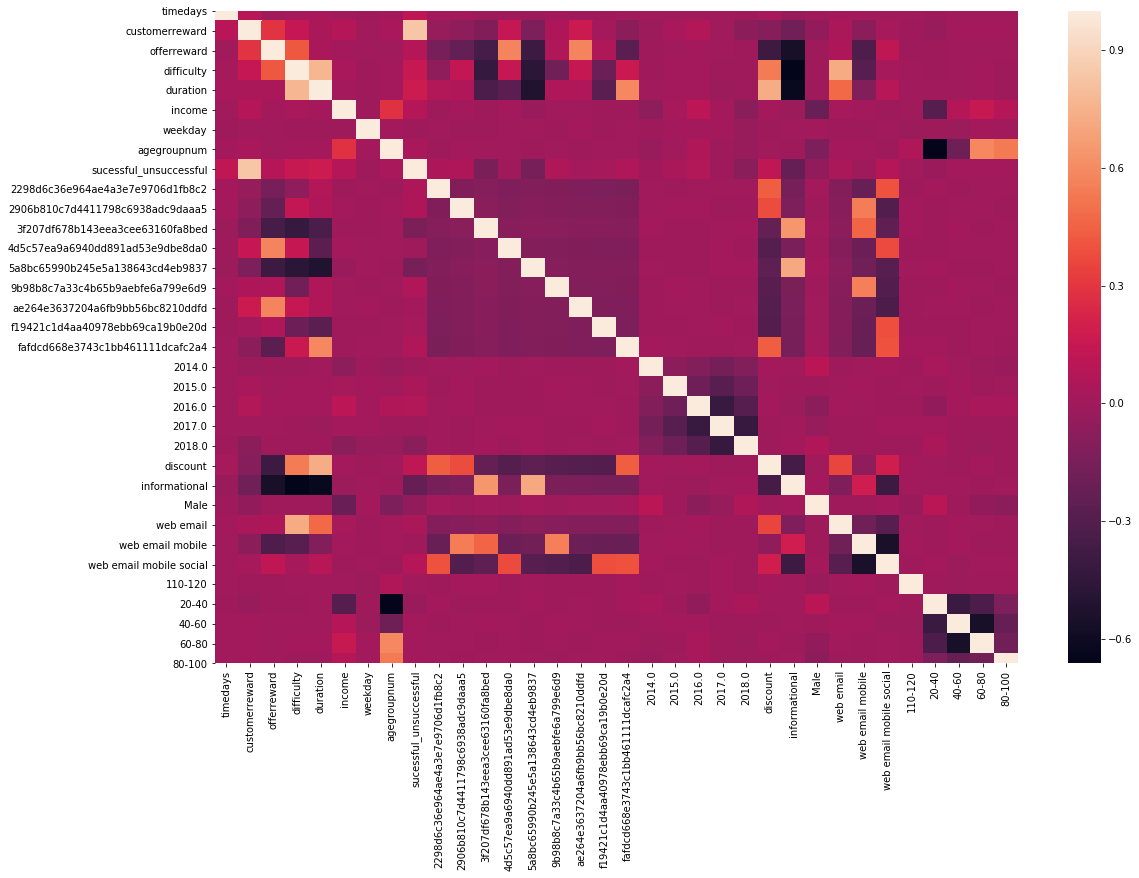

In [1035]:
plt.figure(figsize=(18,12))
sns.heatmap(saleswithoffer_final.corr())

In [1036]:
#Transform variables
##Dataset includes both numeric and one hot encoded categorical variables
##Apply minimum / maximum scaling to numeric variables to avoid model bias
##The use of feature scaling in scikit learn



In [1037]:
saleswithoffer_final['duration'].head()

0     7.0
2     7.0
5     5.0
7     4.0
8    10.0
Name: duration, dtype: float64

In [1038]:
saleswithoffer_final.rename(columns={2014.0: "y2014"}, inplace=True)
saleswithoffer_final.rename(columns={2015.0: "y2015"}, inplace=True)
saleswithoffer_final.rename(columns={2016.0: "y2016"}, inplace=True)
saleswithoffer_final.rename(columns={2017.0: "y2017"}, inplace=True)
saleswithoffer_final.rename(columns={2018.0: "y2018"}, inplace=True)

In [1039]:
saleswithoffer_final.columns

Index(['event', 'timedays', 'customerreward', 'offerreward', 'difficulty',
       'duration', 'becamememberon', 'income', 'weekday', 'agegroupnum',
       'sucessful_unsuccessful', '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '2906b810c7d4411798c6938adc9daaa5', '3f207df678b143eea3cee63160fa8bed',
       '4d5c57ea9a6940dd891ad53e9dbe8da0', '5a8bc65990b245e5a138643cd4eb9837',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'ae264e3637204a6fb9bb56bc8210ddfd',
       'f19421c1d4aa40978ebb69ca19b0e20d', 'fafdcd668e3743c1bb461111dcafc2a4',
       'y2014', 'y2015', 'y2016', 'y2017', 'y2018', 'discount',
       'informational', 'Male', 'web email', 'web email mobile',
       'web email mobile social', '110-120', '20-40', '40-60', '60-80',
       '80-100'],
      dtype='object')

In [1040]:
saleswithoffer_final.rename(columns={'web email': "webemail"}, inplace=True)
saleswithoffer_final.rename(columns={'web email mobile': "webemailmobile"}, inplace=True)
saleswithoffer_final.rename(columns={'web email mobile social': "webemailmobilesocial"}, inplace=True)
saleswithoffer_final.rename(columns={'webemailmobile ': "webemailmobile"}, inplace=True)
saleswithoffer_final.rename(columns={'web email mobile social': "webemailmobilesocial"}, inplace=True)
saleswithoffer_final.rename(columns={'webemailmobile ': "webemailmobile"}, inplace=True)

saleswithoffer_final['2298d6c36e964ae4a3e7e9706d1fb8c2'] = saleswithoffer_final['2298d6c36e964ae4a3e7e9706d1fb8c2'].astype(float)
saleswithoffer_final['2906b810c7d4411798c6938adc9daaa5'] = saleswithoffer_final['2906b810c7d4411798c6938adc9daaa5'].astype(float)
saleswithoffer_final['3f207df678b143eea3cee63160fa8bed'] = saleswithoffer_final['3f207df678b143eea3cee63160fa8bed'].astype(float)
saleswithoffer_final['4d5c57ea9a6940dd891ad53e9dbe8da0'] = saleswithoffer_final['4d5c57ea9a6940dd891ad53e9dbe8da0'].astype(float)
saleswithoffer_final['5a8bc65990b245e5a138643cd4eb9837'] = saleswithoffer_final['5a8bc65990b245e5a138643cd4eb9837'].astype(float)
saleswithoffer_final['9b98b8c7a33c4b65b9aebfe6a799e6d9'] = saleswithoffer_final['9b98b8c7a33c4b65b9aebfe6a799e6d9'].astype(float)
saleswithoffer_final['ae264e3637204a6fb9bb56bc8210ddfd'] = saleswithoffer_final['ae264e3637204a6fb9bb56bc8210ddfd'].astype(float)
saleswithoffer_final['f19421c1d4aa40978ebb69ca19b0e20d'] = saleswithoffer_final['f19421c1d4aa40978ebb69ca19b0e20d'].astype(float)
saleswithoffer_final['fafdcd668e3743c1bb461111dcafc2a4'] = saleswithoffer_final['fafdcd668e3743c1bb461111dcafc2a4'].astype(float)

saleswithoffer_final['y2014'] = saleswithoffer_final['y2014'].astype(float)
saleswithoffer_final['y2015'] = saleswithoffer_final['y2015'].astype(float)
saleswithoffer_final['y2016'] = saleswithoffer_final['y2016'].astype(float)
saleswithoffer_final['y2017'] = saleswithoffer_final['y2017'].astype(float)
saleswithoffer_final['y2018'] = saleswithoffer_final['y2018'].astype(float)

saleswithoffer_final['discount'] = saleswithoffer_final['discount'].astype(float)
saleswithoffer_final['informational'] = saleswithoffer_final['informational'].astype(float)
saleswithoffer_final['Male'] = saleswithoffer_final['Male'].astype(float)
saleswithoffer_final['webemail'] = saleswithoffer_final['webemail'].astype(float)
saleswithoffer_final['webemailmobile'] = saleswithoffer_final['webemailmobile'].astype(float)
saleswithoffer_final['webemailmobilesocial'] = saleswithoffer_final['webemailmobilesocial'].astype(float)
saleswithoffer_final['110-120'] = saleswithoffer_final['110-120'].astype(float)
saleswithoffer_final['20-40'] = saleswithoffer_final['20-40'].astype(float)
saleswithoffer_final['40-60'] = saleswithoffer_final['40-60'].astype(float)
saleswithoffer_final['60-80'] = saleswithoffer_final['60-80'].astype(float)
saleswithoffer_final['80-100'] = saleswithoffer_final['80-100'].astype(float)


saleswithoffer_final.drop('becamememberon', axis=1, inplace=True)
saleswithoffer_final.drop('weekday', axis=1, inplace=True)

dum_event = pd.get_dummies(saleswithoffer_final['event'], drop_first=True)
saleswithoffer_final = pd.concat([saleswithoffer_final, dum_event],axis=1)
saleswithoffer_final.drop(['event'],axis=1,inplace=True) #neighbourhood

saleswithoffer_final.rename(columns={'offer received': "offerreceived"}, inplace=True)
saleswithoffer_final['offerreceived'] = saleswithoffer_final['offerreceived'].astype(float)
saleswithoffer_final.rename(columns={'offer viewed': "offerviewed"}, inplace=True)
saleswithoffer_final['offerviewed'] = saleswithoffer_final['offerviewed'].astype(float)

In [1041]:
# Standadise the columns - Start

In [1042]:
!pip install xgboost
!pip install imblearn
!pip install SVC
!pip install sklearn
!pip install SMOTE

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


# -----

In [1043]:
from sklearn.preprocessing import StandardScaler, normalize  # Helps us in Standardizing the data
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score, average_precision_score # Evaluation
                                                                                                             # metrics
from sklearn.model_selection import train_test_split, GridSearchCV

#from sklearn.cluster import KMeans # Clustering
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE # Oversampling
from sklearn import preprocessing

# -----

In [1044]:

from sklearn.cluster import KMeans # Clustering

variance = []
for k in range(1, 20):
    km = KMeans(n_clusters=k)
    km.fit(saleswithoffer_final.values)
    variance.append(km.inertia_)

Text(0.5, 1.0, 'Elbow')

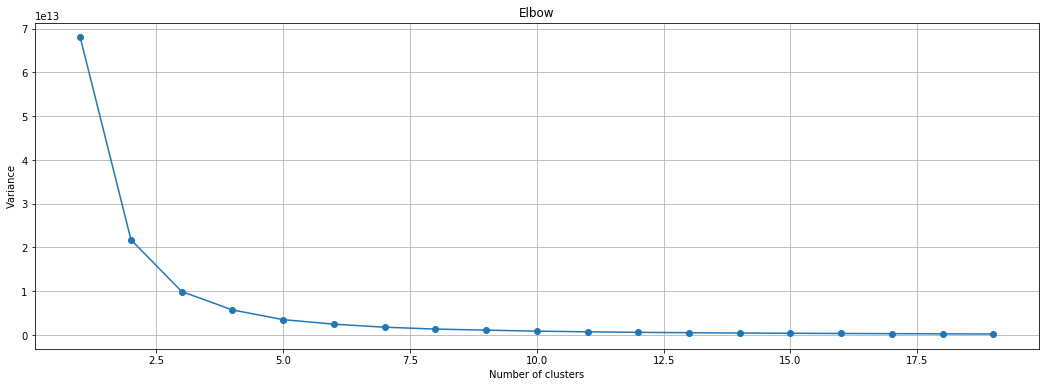

In [1045]:
plt.figure(figsize = (18,6))
plt.plot(range(1, 20), variance, marker='o')
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Variance')
plt.title('Elbow')

In [1046]:
random_state = 101

X = saleswithoffer_final[['timedays', 'customerreward', 'difficulty', 'duration', 'offerreward', 
 'income',  'agegroupnum', '2298d6c36e964ae4a3e7e9706d1fb8c2', '2906b810c7d4411798c6938adc9daaa5', 
 '3f207df678b143eea3cee63160fa8bed', '4d5c57ea9a6940dd891ad53e9dbe8da0', '5a8bc65990b245e5a138643cd4eb9837',
 '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'ae264e3637204a6fb9bb56bc8210ddfd', 'f19421c1d4aa40978ebb69ca19b0e20d', 
 'fafdcd668e3743c1bb461111dcafc2a4', 'y2014', 'y2015', 'y2016', 'y2017', 'y2018', 'discount', 'informational', 
 'Male', 'webemail', 'webemailmobile', 'webemailmobilesocial', '110-120', '20-40', '40-60', '60-80', '80-100',
 'offerreceived', 'offerviewed']]

y= saleswithoffer_final['sucessful_unsuccessful']

tCol = saleswithoffer_final[['timedays', 'customerreward', 'difficulty', 'duration', 'offerreward', 
 'income',  'agegroupnum']]

In [1047]:
X.fillna(0, inplace=True)
X['timedays'].unique()

/Users/akbaralishaikh/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
        6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
        9.  ,  9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  ,
       11.25, 11.5 , 11.75, 12.  , 12.25, 12.5 , 12.75, 13.  , 13.25,
       13.5 , 13.75, 14.  , 14.25, 14.5 , 14.75, 15.  , 15.25, 15.5 ,
       15.75, 16.  , 16.25, 16.5 , 16.75, 17.  , 17.25, 17.5 , 17.75,
       18.  , 18.25, 18.5 , 18.75, 19.  , 19.25, 19.5 , 19.75, 20.  ,
       20.25, 20.5 , 20.75, 21.  , 21.25, 21.5 , 21.75, 22.  , 22.25,
       22.5 , 22.75, 23.  , 23.25, 23.5 , 23.75, 24.  , 24.25, 24.5 ,
       24.75, 25.  , 25.25, 25.5 , 25.75, 26.  , 26.25, 26.5 , 26.75,
       27.  , 27.25, 27.5 , 27.75, 28.  , 28.25, 28.5 , 28.75, 29.  ,
       29.25, 29.5 , 29.75])

In [1048]:
pd.DataFrame(y.value_counts())

,sucessful_unsuccessful
0,114672
1,31943


In [1049]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y,
                            test_size=0.3, random_state=random_state)

In [1050]:
pd.DataFrame(y_train.value_counts())

,sucessful_unsuccessful
0,80153
1,22477


In [1051]:
from collections import Counter
sm = SMOTE(random_state=101)
X_res, y_res = sm.fit_resample(X_train, y_train)
#print('Resampled dataset shape %s' % Counter(y_res))
#--------------------------------------------------------------------
variables_to_scale = ['difficulty', 'timedays', 'offerreward', 'income', 'duration', 'agegroupnum']

variable_names = X.columns

#scaler = preprocessing.RobustScaler()
#X_train[variables_to_scale] = scaler.fit_transform(X_train[variables_to_scale])


scaler = preprocessing.MinMaxScaler()
X_train[variables_to_scale] = scaler.fit_transform(X_train[variables_to_scale])
#--------------------------------------------------------------------

#min_max_scaler = {}

#scaler[cur_column].fit(X[column_idx]
#scaler[cur_column].transform[column_idx]
#min_max_scaler[cur_column].fit(X[column_idx]
#min_max_scaler[cur_column].transform[column_idx]


#for idx in variables_to_scale:
#for idx in range(len(variables_to_scale)):
#    print(idx, variables_to_scale[idx], variable_names, column_idx)
    
#    column_idx = np.argwhere(variable_names == variables_to_scale[idx])[0, 0]
#    cur_column = variables_to_scale[idx]
#scaled_df = pd.DataFrame(scaled_df, columns=['x1', 'x2', 'x3'])
#    print(cur_column)
#    print(X[2:1])
    #min_max_scaler[cur_column] = MinMaxScaler()
    #min_max_scaler[cur_column].fit(X[:, column_idx].reshape(-1, 1))

/Users/akbaralishaikh/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/akbaralishaikh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/akbaralishaikh/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3513: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

In [1052]:
pd.DataFrame(X_train)

,timedays,customerreward,difficulty,duration,offerreward,income,agegroupnum,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,...,webemail,webemailmobile,webemailmobilesocial,110-120,20-40,40-60,60-80,80-100,offerreceived,offerviewed
26804,0.050420,0.0,0.50,0.285714,1.0,0.166667,0.4,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
153032,0.571429,0.0,0.50,0.285714,1.0,0.255556,0.6,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
206569,0.705882,0.0,0.50,0.571429,0.2,0.911111,0.8,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
119300,0.470588,0.0,0.50,1.000000,0.2,0.666667,0.2,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
125898,0.470588,0.0,0.35,0.571429,0.3,0.744444,0.2,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67018,0.235294,0.0,0.35,0.571429,0.3,0.722222,0.4,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
174855,0.596639,3.0,0.35,0.571429,0.3,0.511111,0.4,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
118668,0.470588,0.0,0.50,1.000000,0.2,0.166667,0.6,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
112250,0.470588,0.0,0.50,0.571429,0.2,0.144444,0.6,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [1053]:
'''    column_idx = np.argwhere(variable_names == variables_to_scale[idx])[0, 0]
    
    cur_column = variables_to_scale[idx]
    
    min_max_scaler[cur_column] = MinMaxScaler()
    #min_max_scaler[cur_column].fit(X_train[:, column_idx].reshape(-1, 1))
    min_max_scaler[cur_column].fit(X[:, column_idx].reshape(-1, 1))

    #transformed_values =\
    #    min_max_scaler[cur_column].transform(X_train[:, column_idx].reshape(-1, 1))
    transformed_values =\
        min_max_scaler[cur_column].transform(X[:, column_idx].reshape(-1, 1))

    #X_train[:, column_idx] = transformed_values.reshape(1, -1)
    X[:, column_idx] = transformed_values.reshape(1, -1)
    
    #transformed_values =\
    #    min_max_scaler[cur_column].transform(X_test[:, column_idx].reshape(-1, 1))

    #X_test[:, column_idx] = transformed_values.reshape(1, -1)'''

'    column_idx = np.argwhere(variable_names == variables_to_scale[idx])[0, 0]\n    \n    cur_column = variables_to_scale[idx]\n    \n    min_max_scaler[cur_column] = MinMaxScaler()\n    #min_max_scaler[cur_column].fit(X_train[:, column_idx].reshape(-1, 1))\n    min_max_scaler[cur_column].fit(X[:, column_idx].reshape(-1, 1))\n\n    #transformed_values =    #    min_max_scaler[cur_column].transform(X_train[:, column_idx].reshape(-1, 1))\n    transformed_values =        min_max_scaler[cur_column].transform(X[:, column_idx].reshape(-1, 1))\n\n    #X_train[:, column_idx] = transformed_values.reshape(1, -1)\n    X[:, column_idx] = transformed_values.reshape(1, -1)\n    \n    #transformed_values =    #    min_max_scaler[cur_column].transform(X_test[:, column_idx].reshape(-1, 1))\n\n    #X_test[:, column_idx] = transformed_values.reshape(1, -1)'

In [1054]:
'''import sys
X['timedays'] = X['timedays'].astype('int32')
X['customerreward'] = X['customerreward'].astype('int32')
X['difficulty'] = X['difficulty'].astype('int32')
X['duration'] = X['duration'].astype('int32')
X['offerreward'] = X['offerreward'].astype('int32')
X['income'] = X['income'].astype('int32')
X['agegroupnum'] = X['agegroupnum'].astype('int32')'''

"import sys\nX['timedays'] = X['timedays'].astype('int32')\nX['customerreward'] = X['customerreward'].astype('int32')\nX['difficulty'] = X['difficulty'].astype('int32')\nX['duration'] = X['duration'].astype('int32')\nX['offerreward'] = X['offerreward'].astype('int32')\nX['income'] = X['income'].astype('int32')\nX['agegroupnum'] = X['agegroupnum'].astype('int32')"

In [1055]:
#(X_train, X_test, y_train, y_test) = train_test_split(X, y,
#                            test_size=0.3, random_state=random_state)

In [1056]:
log_reg = LogisticRegression(random_state= random_state)
svc = SVC(random_state= random_state)
rf = RandomForestClassifier(random_state= random_state)
ada = AdaBoostClassifier(random_state= random_state)
xgb = XGBClassifier(random_state= random_state)

In [1057]:
# Lets check the imbalance first
print ('The Imbalance is: {}'.format(np.unique(y_train, return_counts=True)[1][1] / 
                                    (float(np.unique(y_train, return_counts=True)[1][0]) + 
                                    np.unique(y_train, return_counts=True)[1][1])*100))

The Imbalance is: 21.901003605183668


In [1058]:
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)

In [1059]:
print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(102630, 34) (102630,) (43985, 34) (43985,)


In [1060]:
# Lets check the imbalance first
print ('The Imbalance is: {}'.format(np.unique(y_train, return_counts=True)[1][1] / 
                                    (float(np.unique(y_train, return_counts=True)[1][0]) + 
                                    np.unique(y_train, return_counts=True)[1][1])*100))

The Imbalance is: 21.901003605183668


In [1061]:
#sm = SMOTE(ratio={1:24036},kind='borderline1',random_state=random_state) # lets reduce the imbalance 
#sm = SMOTE(ratio=0.1,kind='borderline1',random_state=random_state) # lets reduce the imbalance 

#X_res, y_res = sm.fit_sample(X_train, y_train)

In [1062]:
#print (X_res.shape, y_res.shape)

In [1063]:
'''# Lets check the imbalance first
print ('The Imbalance is reduced now and stands at: {}'.format(np.unique(y_res, return_counts=True)[1][1] / 
                                    (float(np.unique(y_res, return_counts=True)[1][0]) + 
                                    np.unique(y_res, return_counts=True)[1][1])*100))'''

"# Lets check the imbalance first\nprint ('The Imbalance is reduced now and stands at: {}'.format(np.unique(y_res, return_counts=True)[1][1] / \n                                    (float(np.unique(y_res, return_counts=True)[1][0]) + \n                                    np.unique(y_res, return_counts=True)[1][1])*100))"

In [1064]:
# Lets stick to default Hyperparametrs as of now. We shall tune the best model
log_reg = LogisticRegression(random_state= random_state)
svc = SVC(random_state= random_state)
rf = RandomForestClassifier(random_state= random_state)
xgb = XGBClassifier(random_state= random_state)
gbc = GradientBoostingClassifier(random_state= random_state)
ada = AdaBoostClassifier(random_state= random_state)

In [1065]:
def training_predict(trainer, X_train, Y_train, X_test, Y_test):
    scores = {} # Initializing a Dictionary to store evaluation metrics
    
    trainer.fit(X_train, Y_train)  # Training
    Y_pred = trainer.predict(X_test) # Predicts
    
    '''
    Stores the result of trainer in its individual Key
    '''
    scores['Accuracy_test'] = accuracy_score(Y_test , Y_pred)  
    
    scores['Recall_test'] = recall_score(Y_test , Y_pred)
    
    scores['Precision_test'] = precision_score(Y_test , Y_pred)
    
    scores['F1_Score_test'] = f1_score(Y_test , Y_pred, labels=np.unique(Y_pred))
    
    
    return scores

In [1066]:
#print (X_res.shape, y_res.shape, '\n', X_val.shape, y_val.shape)

In [1067]:
# Ignore the error
predictors = {} # Initializing a dictionary to store training and testing data
#for model in [log_reg, svc, rf, ada, xgb]: # these are our objects that we instantiated above. We loop through them
for model in [log_reg, svc, gbc, rf, ada]:#xgb]: # these are our objects that we instantiated above. We loop through them
    model_name = model.__class__.__name__
    predictors[model_name]  = {}
    predictors[model_name] =  training_predict(model, X_train, y_train, X_test, y_test) #Scores that is returned from trainer goes to
                                                                             # the respective predictor

In [1068]:
pd.DataFrame(predictors).T

,Accuracy_test,Recall_test,Precision_test,F1_Score_test
LogisticRegression,0.21521,1.0,0.21521,0.354194
SVC,0.21521,1.0,0.21521,0.354194
GradientBoostingClassifier,1.00000,1.0,1.00000,1.000000
RandomForestClassifier,1.00000,1.0,1.00000,1.000000
AdaBoostClassifier,1.00000,1.0,1.00000,1.000000


In [923]:
smote_values = np.linspace(0.065, 0.125, num= 15)
smote_values

array([0.065     , 0.06928571, 0.07357143, 0.07785714, 0.08214286,
       0.08642857, 0.09071429, 0.095     , 0.09928571, 0.10357143,
       0.10785714, 0.11214286, 0.11642857, 0.12071429, 0.125     ])

In [ ]:
import time

#Ignore the errors
start = time.time()

panel = {} # Saves key as smoting ratio and dictionary is the result of each classifier

(X_train, X_test, y_train, y_test) = train_test_split(X, y,
                            test_size=0.3, random_state=random_state)

for value in smote_values:
    value
    sm = SMOTE(ratio=value,kind='borderline1',random_state=42)
    X_res, Y_res = sm.fit_sample(X_train, y_train)

    print ('Loop for smote value {} started at {}'.format(value, datetime.now().strftime("%H:%M:%S")))
   
    predictors = {} # Initializing a dictionary to store training and testing data
 
    for model in [log_reg, svc, rf, ada, xgb]:
        model_name = model.__class__.__name__
        predictors[model_name]  = {}
        predictors[model_name] =  training_predict(model, X_train, y_train, X_test, y_test) #Scores that is returned from trainer goes to
    
    panel[value] = predictors  # the respective predictor
            
    print ('Loop Ended at {}'.format(datetime.now().strftime("%H:%M:%S")))
    print ('\n')
    
print ('Loop took {} mins'.format((time.time() - start) / 60))

In [279]:
# Lets check the imbalance first
print ('The Imbalance is: {}'.format(np.unique(y_train, return_counts=True)[1][1] / 
                                    (float(np.unique(y_train, return_counts=True)[1][0]) + 
                                    np.unique(y_train, return_counts=True)[1][1])*100))

The Imbalance is: 21.901003605183668


In [280]:
sm = SMOTE(random_state=101, ratio=1.0)

In [281]:
X_smote_train, y_smote_train = sm.fit_resample(X_train, y_train)

/Users/akbaralishaikh/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [282]:
X_smote_train = pd.DataFrame(X_train, columns=X_train.columns)

In [283]:
X_smote_train.columns

Index(['timedays', 'customerreward', 'difficulty', 'duration', 'offerreward',
       'income', 'agegroupnum', '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '2906b810c7d4411798c6938adc9daaa5', '3f207df678b143eea3cee63160fa8bed',
       '4d5c57ea9a6940dd891ad53e9dbe8da0', '5a8bc65990b245e5a138643cd4eb9837',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'ae264e3637204a6fb9bb56bc8210ddfd',
       'f19421c1d4aa40978ebb69ca19b0e20d', 'fafdcd668e3743c1bb461111dcafc2a4',
       'y2014', 'y2015', 'y2016', 'y2017', 'y2018', 'discount',
       'informational', 'Male', 'webemail', 'webemailmobile',
       'webemailmobilesocial', '110-120', '20-40', '40-60', '60-80', '80-100',
       'offerreceived', 'offerviewed'],
      dtype='object')

In [284]:
Y_smote_train = pd.Series(y_smote_train)

In [285]:
# Lets check the imbalance first
print ('The Imbalance is: {}'.format(np.unique(y_smote_train, return_counts=True)[1][1] / 
                                    (float(np.unique(y_smote_train, return_counts=True)[1][0]) + 
                                    np.unique(y_smote_train, return_counts=True)[1][1])*100))

The Imbalance is: 50.0


In [286]:
print(X_smote_train.shape, y_smote_train.shape, X_test.shape, y_test.shape)

(102630, 34) (160306,) (43985, 34) (43985,)


In [278]:
# Ignore the error
predictors = {} # Initializing a dictionary to store training and testing data
for model in [log_reg, svc, rf, ada, xgb]: # these are our objects that we instantiated above. We loop through them
    model_name = model.__class__.__name__
    predictors[model_name]  = {}
    predictors[model_name] =  training_predict(model, X_test, y_test, X_smote_train, y_smote_train) #Scores that is returned from trainer goes to
                                                                             # the respective predictor

ValueError: Found input variables with inconsistent numbers of samples: [160306, 102630]

In [ ]:
# Get column names first

names = saleswithoffer_final[['timedays', 'customerreward', 'difficulty', 
        'duration', 'offerreward', 'income',  'agegroupnum']]

scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(names)
X_scaled_df = pd.DataFrame(scaled_df, columns=names.columns)
X_scaled_df

In [ ]:
# Ignore the error
predictors = {} # Initializing a dictionary to store training and testing data
for model in [log_reg, svc, rf, ada, xgb]: # these are our objects that we instantiated above. We loop through them
    model_name = model.__class__.__name__
    predictors[model_name]  = {}
    predictors[model_name] =  training_predict(model, X_train, y_train, X_test, y_test) #Scores that is returned from trainer goes to
                                                                             # the respective predictor

# Test

In [ ]:
pd.DataFrame(predictors).T

In [ ]:
smote_values = np.linspace(0.065, 0.125, num= 15)
smote_values

In [ ]:
X_train, y_train

In [ ]:
scaled_df

In [ ]:
smote_iterated_df = pd.DataFrame()
for key in panel:
    temp_df = pd.DataFrame(panel[key]).T
    temp_df['Smote'] = key
    temp_df.index.name = 'Class'
    temp_df.reset_index(inplace= True)
    temp_df.set_index(['Smote','Class'], inplace= True)
    smote_iterated_df = smote_iterated_df.append(temp_df)

In [ ]:
smote_iterated_df.head(15)


In [ ]:
# Lets rearrange Recall_test score in descending order
smote_iterated_df['Recall_test'].sort_values(ascending = False).head(5)

In [ ]:
smote_iterated_df['Recall_test'].idxmax() # Finding the Smote_Ratio and Class for the largest Recall Score

In [ ]:
smote_iterated_df.to_csv('Smote_iteration.csv', sep=',')

In [ ]:
ALPHA

In [ ]:
#-----------

In [ ]:
#---------------------------------------------------------------------------------------------------------------
variables_to_scale = ['timedays', 'customerreward', 'difficulty', 
                      'duration', 'offerreward', 'income', 'agegroupnum']

min_max_scaler = {}

scaler = MinMaxScaler()
scaler.fit(X_train[variables_to_scale])
X_train = scaler.transform(X_train[variables_to_scale])


In [ ]:
'''Predictive Modeling
Evaluate naive predictor performance
A naive predictor assumes that all customer offers were successful'''

In [ ]:
naive_predictor_accuracy = accuracy_score(y_train,np.ones(len(y_train)))
naive_predictor_f1score = f1_score(y_train, np.ones(len(y_train)))

print("Naive predictor accuracy: %.3f" % (naive_predictor_accuracy))
print("Naive predictor f1-score: %.3f" % (naive_predictor_f1score))

In [ ]:
scorer = make_scorer(fbeta_score,
                     beta=0.5)


lr_clf = LogisticRegression(random_state=random_state,
                            solver='liblinear')

random_grid = {'penalty': ['l1', 'l2'],
               'C': [1.0, 0.1, 0.01]}

lr_random = RandomizedSearchCV(estimator = lr_clf,
                               param_distributions = random_grid,
                               scoring=scorer,
                               n_iter = 6,
                               cv = 3,
                               verbose=2,
                               random_state=random_state,
                               n_jobs = 3)

lr_random.fit(X_train, y_train)

In [ ]:
def evaluate_model_performance(clf,
                               X_train,
                               y_train):
    """ Prints a model's accuracy and F1-score
    
    INPUT:
        clf: Model object
        
        X_train: Training data matrix

        y_train: Expected model output vector
    
    OUTPUT:
        clf_accuracy: Model accuracy
        
        clf_f1_score: Model F1-score"""
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]

    y_pred_rf = clf.predict(X_train)

    clf_accuracy = accuracy_score(y_train, y_pred_rf)
    clf_f1_score = f1_score(y_train, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    
    return clf_accuracy, clf_f1_score

In [ ]:
evaluate_model_performance(lr_random.best_estimator_,
                           X_train,
                           y_train)

In [ ]:
rf_clf = RandomForestClassifier(random_state=random_state)

# Number of trees in random forest
n_estimators = [10, 30, 50, 100, 150, 200, 250, 300]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(3, 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rf_random = RandomizedSearchCV(estimator = rf_clf,
                               param_distributions = random_grid,
                               scoring=scorer,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=random_state,
                               n_jobs = 3)

rf_random.fit(X_train, y_train)

In [ ]:
evaluate_model_performance(rf_random.best_estimator_,
                           X_train,
                           y_train)

In [ ]:
relative_importance = rf_random.best_estimator_.feature_importances_
relative_importance = relative_importance / np.sum(relative_importance)

feature_importance =\
    pd.DataFrame(list(zip(variable_names,
                          relative_importance)),
                 columns=['feature', 'relativeimportance'])

feature_importance = feature_importance.sort_values('relativeimportance',
                                                    ascending=False)

feature_importance = feature_importance.reset_index(drop=True)

palette = sns.color_palette("Blues_r", feature_importance.shape[0])

plt.figure(figsize=(8, 8))
sns.barplot(x='relativeimportance',
            y='feature',
            data=feature_importance,
            palette=palette)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Random Forest Estimated Feature Importance')

In [ ]:
feature_importance.head(n=10)

In [ ]:
gb_clf = GradientBoostingClassifier(random_state=random_state)

# Create the random grid
random_grid = {'loss': ['deviance', 'exponential'],
               'learning_rate': [0.1, 0.01, 0.001],
               'n_estimators': [10, 30, 50, 100, 150, 200, 250, 300],
               'min_samples_leaf': min_samples_leaf,
               'min_samples_split': min_samples_split}

gb_random = RandomizedSearchCV(estimator = gb_clf,
                               param_distributions = random_grid,
                               scoring=scorer,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=random_state,
                               n_jobs = 3)

gb_random.fit(X_train, y_train)



In [ ]:
evaluate_model_performance(gb_random.best_estimator_,
                           X_train,
                           y_train)